In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
import numpy.random as rng

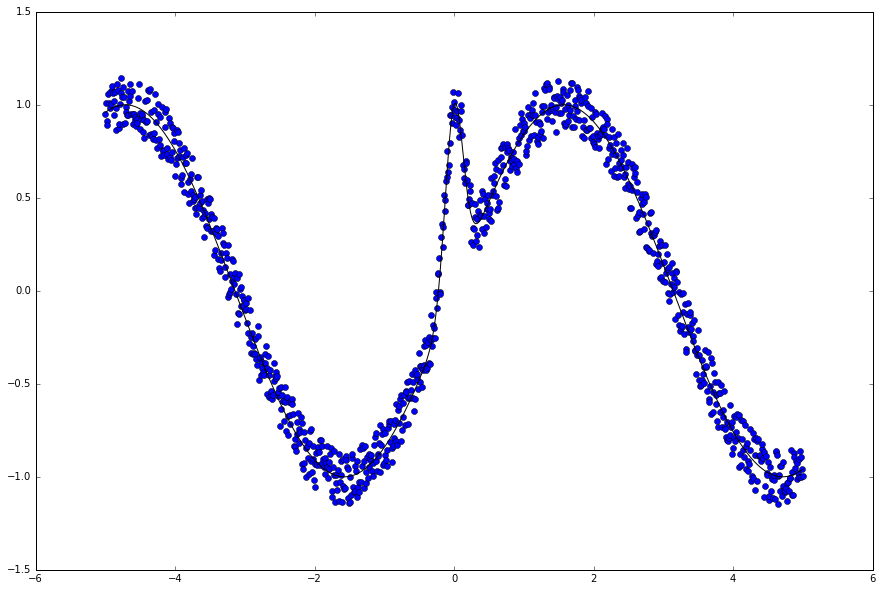

In [35]:
nObs = 1000
x1 = np.linspace(-5,5,nObs).reshape(nObs,1)
noise = np.random.uniform(-0.15,0.15,nObs).reshape(nObs,1)
f = lambda x: np.sin(x) + np.exp(-30*x**2)
y_exact = f(x1)
y = y_exact + noise
#y = np.clip(y,-1,1)
XY = np.hstack((x1,y))
plt.plot(x1,y,'bo',x1,y_exact,'k')
plt.show()

In [3]:
def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.scalar_summary('mean/' + name, mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.scalar_summary('stddev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.histogram_summary(name, var)

In [28]:
# With BN

def bn(x,feats,epsilon=0.0001):
    # Calculate batch mean and variance
    batch_mean1, batch_var1 = tf.nn.moments(x,[0])

    # Apply the initial batch normalizing transform
    normed = (x - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

    # Create two new parameters, scale and beta (shift)
    scale1 = tf.Variable(tf.ones([feats]))
    beta1 = tf.Variable(tf.zeros([feats]))

    # Scale and shift to obtain the final output of the batch normalization
    # this value is fed into the activation function (here a sigmoid)
    return scale1 * normed + beta1 # return batch normalized layer

X = tf.placeholder(tf.float32,[None,1])
yTruth = tf.placeholder(tf.float32,[None,1])

W = tf.Variable(tf.random_normal([1, 200], stddev=0.15),
                      name="weights")
b = tf.Variable(tf.zeros([200]),"float32")

h1 = tf.nn.tanh(bn(tf.matmul(X, W) + b,200))

W1 = tf.Variable(tf.random_normal([200, 200], stddev=0.15),
                      name="weights")
b1 = tf.Variable(tf.zeros([200]),"float32")

h2 = tf.nn.tanh(bn(tf.matmul(h1, W1) + b1,200))

W2 = tf.Variable(tf.random_normal([200, 10], stddev=0.15),
                      name="weights")
b2 = tf.Variable(tf.zeros([10]),"float32")

h3 = tf.nn.tanh(tf.matmul(h2, W2) + b2)

W3 = tf.Variable(tf.random_normal([10, 1], stddev=0.15),
                      name="weights")
b3 = tf.Variable(tf.zeros([1]),"float32")

h4 = tf.nn.tanh(tf.matmul(h3, W3) + b3)

W4 = tf.Variable(tf.random_normal([1, 1], stddev=0.15),
                      name="weights")
b4 = tf.Variable(tf.zeros([1]),"float32")

yPred = tf.matmul(h4, W4) + b4

In [33]:
for l in [X,h1,h2,h3,yPred]:
    print(l.get_shape().as_list())

mse = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(yPred, yTruth))))
optim = tf.train.AdamOptimizer(0.001).minimize(mse)
variable_summaries(mse,"mse")
merged = tf.merge_all_summaries()
train_writer = tf.train.SummaryWriter("summary")

[None, 1]
[None, 200]
[None, 200]
[None, 10]
[None, 1]


0.728047
0.714578
0.684129
0.654634
0.61614
0.619422
0.637241
0.595977
0.553845
0.575067
0.572836
0.600218
0.545663
0.562868
0.600431
0.594123
0.558113
0.541389
0.543799
0.596937
0.556279
0.59067
0.582406
0.572461
0.547356
0.549367
0.5912
0.545592
0.554414
0.608047
0.54812
0.551045
0.536888
0.506573
0.551713
0.533041
0.524612
0.54647
0.490949
0.581312
0.529884
0.538938
0.549934
0.541328
0.552514
0.519686
0.533401
0.53681
0.51884
0.504972


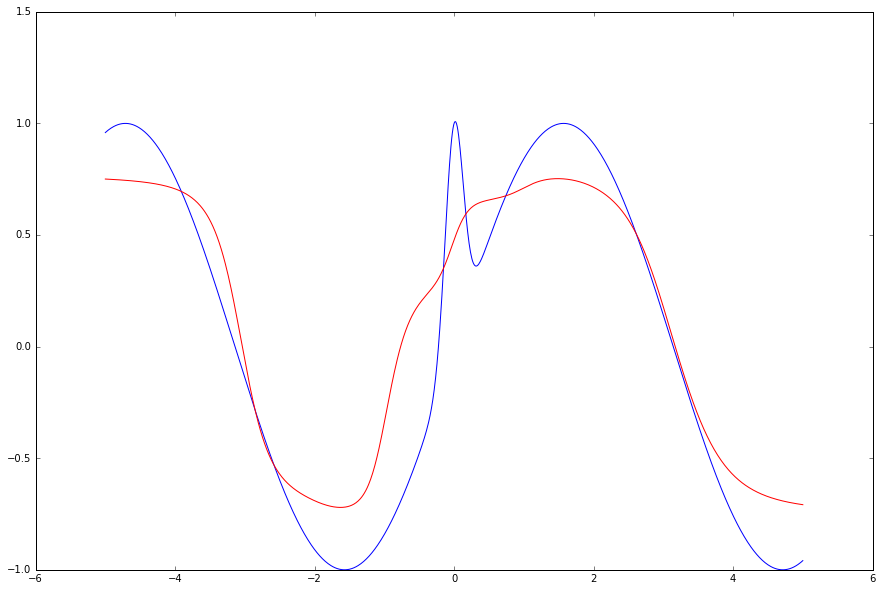

In [36]:
bS = 10
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    plt.plot(x1,f(x1))
    for epoch in xrange(50):
        XY = XY[rng.permutation(XY.shape[0])]
        nObs = XY.shape[0]
        losses = []
        for i in xrange(0,nObs,bS):
            x,y = XY[i:i+bS][:,0].reshape(bS,1), XY[i:i+bS][:,1].reshape(bS,1)
            
            _, yPred_, mse_ = sess.run([optim,yPred,mse], feed_dict={X:x,yTruth:y})
            losses.append(mse_)
        print(np.array(losses).mean())     
    # Fit
    fit = sess.run(yPred,feed_dict={X:x1})
    plt.plot(x1,fit,c=(1.0,0.0,0.0),label=str(mse))
    plt.show()